# 순환 신경망으로 IMDB 리뷰 분류하기

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/hg-mldl/blob/master/9-2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

리뷰 데이터셋은 수집한 리뷰를 감상평에 따라 긍정과 부정으로 분류해 놓은 데이터셋이고 텍스트 데이터의 경우 숫자 데이터로 분리하는데 이렇게 분리된 단어를 토큰이라고 부른다. 하나의 샘플은 여러 개의 토큰으로 이루어져 있고 1개의 토큰이 하나의 타임스텝에 해당

In [1]:
# # 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다. 
# import tensorflow as tf

# tf.keras.utils.set_random_seed(42)
# tf.config.experimental.enable_op_determinism()

## IMDB 리뷰 데이터셋

In [2]:
from tensorflow.keras.datasets import imdb

(train_input, train_target), (test_input, test_target) = imdb.load_data(
    num_words=500) # 전체 데이터 셋에서 가장 자주 등장하는 단어 500개만 사용, (당연히 num_words는 패션데이터에서 쓸수 없음)

In [3]:
print(train_input.shape, test_input.shape) # 각각 25000개씩 분류 총 5만개샘플

(25000,) (25000,)


In [4]:
print(len(train_input[0])) # 첫 번째 리뷰의 길이

218


In [5]:
print(len(train_input[1])) # 두번째 리뷰의 길이

189


In [6]:
print(train_input[0]) # 첫번째 리뷰 내용

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


In [7]:
print(train_target[:20]) # 부정(0)과 긍정(1)로 타깃설정 되어있고 리뷰20개 판단

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


In [8]:
from sklearn.model_selection import train_test_split

train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42) # 검증세트 0.2%

In [9]:
# 평균적인 리뷰와 가장 짧은 길이 그리고 가장 긴 리뷰를 확인
import numpy as np 
lengths = np.array([len(x) for x in train_input]) #(훈련데이터 샘플) 리뷰 길이를 배열로 담기

In [10]:
print(np.mean(lengths), np.median(lengths)) # 리뷰길이 평균, 중간값

239.00925 178.0


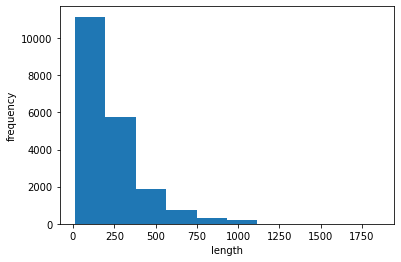

In [11]:
import matplotlib.pyplot as plt

plt.hist(lengths) # 히스토그램으로 리뷰길이 빈도수 확인
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()
# 짧은 리뷰가 더 많은 것을 확인

In [12]:
# 예제에서는 중간값보다 훨씬 짧은 100개의 단어만 사용. 하지만 100개보다 작은 리뷰가 있는데 이 길이를 맞추기 위해 패딩을 사용하고
# 패딩을 나타내는 토큰으로는 0을 사용 
# >> 위 작업을 편리하게 해주는 클래스사용 
from tensorflow.keras.preprocessing.sequence import pad_sequences 

train_seq = pad_sequences(train_input, maxlen=100) 

In [13]:
print(train_seq.shape) # 각 20000개 샘플의 길이100 >> 2차원 배열

(20000, 100)


In [14]:
print(train_seq[0]) # 첫번째 샘플의 내용

[ 10   4  20   9   2 364 352   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10 451   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10 470 158]


In [15]:
print(train_input[0][-10:]) 

[6, 2, 46, 7, 14, 20, 10, 10, 470, 158]


In [16]:
print(train_seq[5])

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2 352   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94 364 352   2   2  11 190
  24 484   2   7  94 205 405  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


In [17]:
val_seq = pad_sequences(val_input, maxlen=100) # 5000개의 샘플을 길이100으로 변환
print(val_seq)

[[ 32   2 225 ...  14  58   2]
 [ 53   2   8 ...   7  32   2]
 [  0   0   0 ...   2  33  32]
 ...
 [383   2 120 ...  16  99  76]
 [106 345  12 ... 120   2 156]
 [  4 114  21 ...   4   2   2]]


## 순환 신경망 만들기

In [18]:
from tensorflow import keras

model = keras.Sequential() # 인공 신경망 객체 모델 생성

model.add(keras.layers.SimpleRNN(8, input_shape=(100, 500))) # 순환층 클래스(뉴런의 개수, input_shape(샘플의 길이100, 500), activation기본값= tnah)
model.add(keras.layers.Dense(1, activation='sigmoid')) # 이진분류이므로 마지막 출력층은 1개의 뉴런을 가지고 시그모이드 활성화 함수를 사용

토근을 정수로 변환한 이 데이터를 신경망에 주입하면 큰 정수가 큰 활성화 출력을 만드는데 이 정수 사이에는 분명 어떠한 관련도 없고 없어야됨. 
>> 따라서 단순한 정수값을 신경망에 입력하기 위해 각 고유한 정수를 표현하는 원-핫 인코딩이 필요

In [19]:
train_oh = keras.utils.to_categorical(train_seq) # 원-핫 인코딩 (훈련세트)

In [20]:
print(train_oh.shape) # 정수 하나마다 모두 500차원의 배열로 변경 되었기 때문에 위에 input_shpae 매개변수 값을 100,200으로 지정한 것임

(20000, 100, 500)


In [21]:
print(train_oh[0][0][:12]) # 첫번째 샘플의 첫번째 단어(토큰)의 인코딩?

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [22]:
print(np.sum(train_oh[0][0])) # 첫번째 샘플의 첫번째 단어(토큰)

1.0


In [23]:

val_oh = keras.utils.to_categorical(val_seq) # (검증세트도 변환)

In [24]:
model.summary() 
# 순환층에 전달할 샘플의 크기는 (100,200)이지만 이 순환층은 마지막 타임스텝의 은닉 상태만 출력하기 때문에
# 출력크기가 순환층의 뉴런개수와 동일 8개

# 500차원의 원-핫 인코딩 배열과 8개 뉴런이 완전히 연결 되었기 때문에 4000개의 가중치가 있고 
# 순환층의 은닉 상태는 다시 타음스텝에 사용되기 위해 8*8 =64개의 가중치가 필요하고 
# 뉴런8개 마다 하나의 절편이 있어 
# 총 4081개의 모델 파라미터가 필요

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 4072      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________


## 순환 신경망 훈련하기

In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', # rmsprop옵티마이저, 손실함수=이진분류, 정확도표기
              metrics=['accuracy'])

# 체크포인트와 조기 종료를 구성하는 코드
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, 
                                                  restore_best_weights=True)

# 순환클래스 모델 훈련
history = model.fit(train_oh, train_target, epochs=100, batch_size=64,
                    validation_data=(val_oh, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

# 80프로의 성능을 보여줌

Epoch 1/100
313/313 [==============================] - 31s 85ms/step - loss: 0.6984 - accuracy: 0.5120 - val_loss: 0.6950 - val_accuracy: 0.5174
Epoch 2/100
313/313 [==============================] - 15s 49ms/step - loss: 0.6929 - accuracy: 0.5220 - val_loss: 0.6914 - val_accuracy: 0.5274
Epoch 3/100
313/313 [==============================] - 17s 55ms/step - loss: 0.6894 - accuracy: 0.5313 - val_loss: 0.6887 - val_accuracy: 0.5342
Epoch 4/100
313/313 [==============================] - 17s 53ms/step - loss: 0.6863 - accuracy: 0.5443 - val_loss: 0.6863 - val_accuracy: 0.5412
Epoch 5/100
313/313 [==============================] - 15s 49ms/step - loss: 0.6832 - accuracy: 0.5565 - val_loss: 0.6838 - val_accuracy: 0.5520
Epoch 6/100
313/313 [==============================] - 15s 48ms/step - loss: 0.6799 - accuracy: 0.5688 - val_loss: 0.6808 - val_accuracy: 0.5590
Epoch 7/100
313/313 [==============================] - 15s 49ms/step - loss: 0.6758 - accuracy: 0.5803 - val_loss: 0.6767 - val_ac

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()
# 검증세트의 손실감소가 둔해지는 구간 에포크 지점 확인

## 단어 임베딩을 사용하기

순환 신경망에서 텍스트를 처리할 때 즐겨 사용하는 방법으로 단어 임베딩이 있는데 각 다너를 고정된 크기의 실수 벡터로 바꾸어 준다.
이런 단어 임베딩으로 만들어진 벡터는 원-핫인코딩 된 벡터보다 후러씬 의미 있는 값으로 채워져 자연어 처리에서 더 좋은 성능을 내는 경우가 있음.

In [ ]:
model2 = keras.Sequential() 

# 단어 임베딩 층을 제공하는 Embedding클래스(), 첫번째 매객변수 500은 어휘 사전의 크기지정<< 앞서 리뷰데이터셋에서 단어500개만 사용하도록 설정했기 때문에 지정
# 두번째 매개변수는 임베딩 벡터 크기, 세번째는 샘플 데이터 길이
model2.add(keras.layers.Embedding(500, 16, input_length=100))  
model2.add(keras.layers.SimpleRNN(8)) # 순환층 클래스(뉴런의 개수, activation기본값= tnah)
model2.add(keras.layers.Dense(1, activation='sigmoid')) # 출력층 

model2.summary()

In [ ]:
# 모델 컴파일
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', 
               metrics=['accuracy'])

# 체크포인트와 조기종료
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-embedding-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

# 모델2 훈련
history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])
# 결과를 보명 원-핫 인코딩을 사용한 모델과 원-핫 인코딩을 사용하지 않은 train_seq과 val_seq을 이용한 임베딩 방법은
# 비슷한 성능을 내지만 순환층의 가중치개수는 훨찍 작고 훈련 세트 크기도 줄음

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()
# 검증손실은 특정 부분에서 더 이상 감소가 일어나지 않아 조기종료 되었고 훈련손실은 계속 진행됨